# Mini-EUSO trigger visualisation

The Mini-EUSO trigger algortihm can be tested in software using the C++ trigger algorithm and visualised with this code.

## File naming convention:  
level 1 data files end in .dl1, level 2 in .dl2 and level 3 in .dl3  
level 1 trigger files end in .tr1, level 2 in .tr2, level 3 in .tr3   

## Data format (text file):  
time step # (GTU or GTU_L2 or GTU_L3)  
             
             pix0  pix1  pix2 ... pix47  
             ...   ...   ...  ...  ...  
             ...   ...   ...  ... pix2303
            

## Data format (trigger file):  
GTU # -  packet #   - pixel #  - pixel signal - pixel-1 signal - pixel+1 signal

## Notes
* 1 packet = 128 time steps (GTU or GTU_L2 or GTU_L3)
* Make sure to include at least 128 GTU or GTU_L2 of background at the beginning of the file for the trigger to set the thresholds

## Examples

1. For level 1 use ```file_name = 'l1_single_event'```
2. For level 2 use ```file_name = 'l2_single_event'```

To run:
* import what is needed

In [29]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as const
import seaborn as sns
from subprocess import call
import sys
sys.path.append('../')
from euso_plotting_tools import *

* Define the file name (store file in ```../data/``` without the .dl* suffix) and select level 1 or level 2 inputs

In [44]:
file_name = 'l2_single_event'

path = '../../data/'

# select trigger level
level=2

if level == 1:
    data_file = path + file_name + '.dl1'
    trig_file = path + file_name + '.tr1'
    dt = 2.5e-6 # time step per GTU
elif level == 2:
    data_file = path + file_name + '.dl2'
    trig_file = path + file_name + '.tr2'
    dt = 2.5e-6 * 128 # time step per GTU_L2
else: 
    print 'ERROR: Please select one trigger level'

* Run the C++ trigger algorithm on the data  
To compile, use the command ```make``` inside the ```software_trigger/``` directory   
If successful, the call will return 0

In [45]:
# Run the C++ trigger to generate the trigger data
#call(["./a.out", "args", "to", "spa"])

if level == 1:
    call(["../bin/l1_trigger", file_name])
elif level == 2:
    call(["../bin/l2_trigger", file_name])
else:
    print 'ERROR: Please select one trigger level'

* Read in the data and the output trigger file 

* Plot the lightcurve for the pixels that trigger, along with the trigger itself  
Each pixel lightcurve is plotted only once

In [46]:
# Read the data_file into an array
with open(data_file) as f:
    data = []
    for line in f:
        line = line.split() 
        if line:            
            line = [int(i) for i in line]
            data.append(line)

data = np.array(data)
len = np.shape(data)[0]
ind = range(0, len, 49)

# nz = total number of time steps
nz_check = int(data[ind[-1]][0])
nz = (np.shape(ind))[0] - 1
if nz_check != nz:
    print 'WARNING: GTU labelling does not agree with file length'
    print '# of gtu by label:', nz_check
    print '# of gtu by file length', nz
    print 'Using # of gtu = ', nz

# initialise the counts array and the time array
counts = np.zeros((nz, 2304)) 
t = np.arange(0, round(nz * dt, 10), dt)

if np.shape(counts)[0] < 128:
    print 'ERROR: The input data file is not long enough!'

# pull out the counts from the data file, skipping the time step 
for iz in range(nz):
    counts[iz][:] = np.concatenate((data[ind[iz] + 1 : ind[iz] + 49]), axis = 0)


# read the trig_file into an array
with open(trig_file) as f:
    trig = []
    for line in f:
        line = line.split() 
        if line:            
            line = [float(i) for i in line]
            trig.append(line)

# of gtu by label: 629
# of gtu by file length 628
Using # of gtu =  628


# of triggers: 1


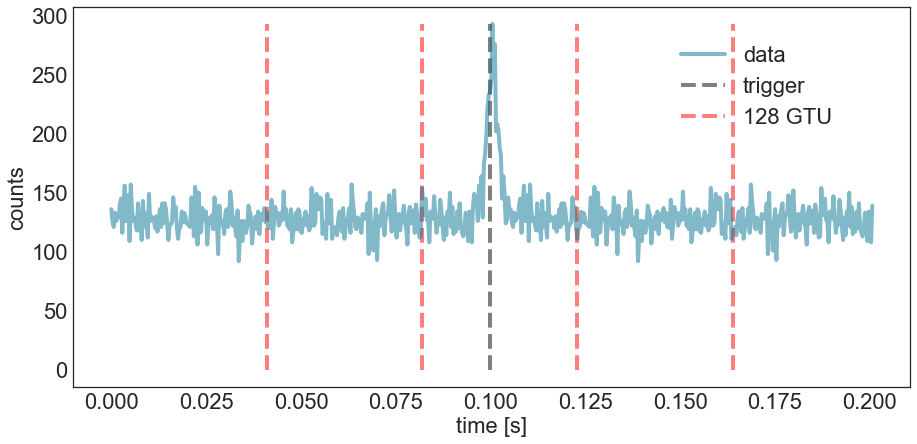

In [47]:
# Set the plotting style
sns.set_style("white")
fs = 22
sns.set_context("paper", rc={"font.size":fs, "axes.titlesize":fs, "axes.labelsize":fs, 
                             "xtick.labelsize":fs, "ytick.labelsize":fs})   
# initialise frame of v
trig_t = []

# Plot light curve for the pixels that trigger
plt.figure(figsize=(15, 7))

y_max_list = []
for nt in range(np.shape(trig)[0]):
    # Get the exact location of the trigger using loop position
    trig_t.append((trig[nt][0]) + (trig[nt][1] * 128))
    
    #Get the pixel nuumber
    i = int(trig[nt][2])
    
    if nt > 0 and i == i_old:
        continue # only plot each pixel once
    else:
        if nt == (np.shape(trig)[0]) - 1:
            plt.plot(t, counts[:, i], LineWidth = 4, color = sns.xkcd_rgb["sea blue"],
                     alpha = 0.5, label = "data") # only make one legend label 
            y_max_list.append(np.max(counts[:, i]))
        else:
            plt.plot(t, counts[:, i], LineWidth = 4, color = sns.xkcd_rgb["sea blue"], alpha = 0.5)
            y_max_list.append(np.max(counts[:, i]))
    i_old = i

# Get the max value for the y-axis
if (np.shape(y_max_list)[0] > 0):
    y_max = np.max(y_max_list)
else:
    y_max = 50

# Plot the triggers on top with dashed lines
trig_t = np.array(trig_t)
gtu = np.array(range(128, nz, 128))
plt.vlines(trig_t * dt, 0, y_max, LineWidth = 4, colors='k', linestyles='dashed', label='trigger', alpha = 0.5)
# To see every 128 GTU
plt.vlines(gtu * dt, 0, y_max, LineWidth = 4, colors='r', linestyles='dashed', label='128 GTU', alpha = 0.5)

# Label the plot and add legend
plt.xlabel('time [s]')
plt.ylabel('counts')
lgd = plt.legend(bbox_to_anchor=(0.93, 0.95), fontsize = fs)
#plt.xlim([0., 0.09664]) # Tidying up for presentation plots

# Save the figure at high resolution for presentation plots
#plt.savefig('trig_vis_MixEBG_14L2.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 500)

#print number of triggers 
n_trig = np.shape(trig_t)[0]
print('# of triggers: ' + str(n_trig))



* Plot the triggered frames as a 2D image of the whole focal surface

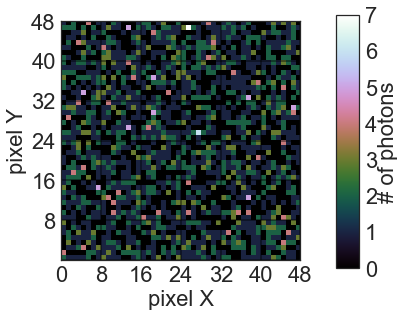

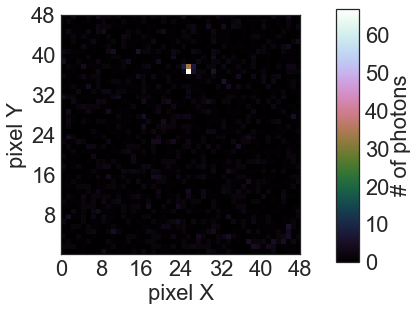

In [18]:
# Plot the focal surface view
for nt in range(np.shape(trig)[0]):
    if int(trig_t[nt]) > nz:
        print 'ERROR: This GTU is out of the range of the data file, for trigger # ', nt
        print 'Try to pass as input a data file with the total number of GTU divisible by 128'
    else:
        fs = np.array(counts[int(trig_t[nt])][:]).reshape(48, 48)
        plot_focal_surface(fs)


In [19]:
# Check the triggered pixel values
print 'Trigger'
for nt in range(np.shape(trig)[0]):
    print 'int: ', trig[nt][3], ' hex16: ', hex(int(trig[nt][3]))  
    
# Check the -1 pixel values
print 'Trigger-1'
for nt in range(np.shape(trig)[0]):
    print 'int: ', trig[nt][4], ' hex16: ', hex(int(trig[nt][4]))
     
# Check the +1 pixel values
print 'Trigger+1'
for nt in range(np.shape(trig)[0]):
    print 'int: ', trig[nt][5], ' hex16: ', hex(int(trig[nt][5]))

Trigger
int:  5.0  hex16:  0x5
int:  9.0  hex16:  0x9
Trigger-1
int:  2.0  hex16:  0x2
int:  2.0  hex16:  0x2
Trigger+1
int:  1.0  hex16:  0x1
int:  29.0  hex16:  0x1d
